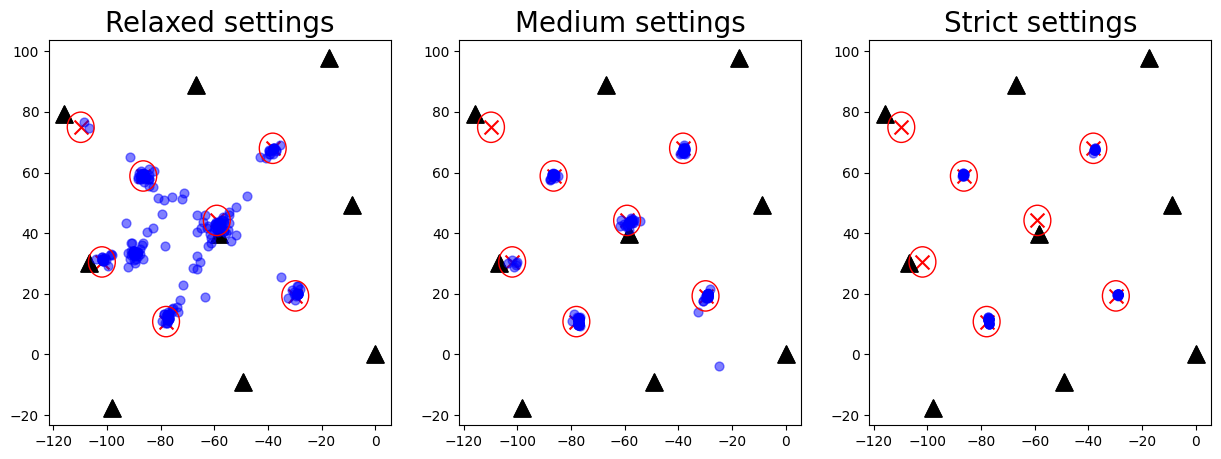

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

# plot the speakers as large red crosses
speakers = pd.read_csv('./inputs/speaker_coords.csv')
arus = pd.read_csv('./inputs/aru_coords.csv')

titles = ["Relaxed settings", "Medium settings", "Strict settings"]
# flatten the axes
ax = ax.flatten()
for i, settings in enumerate(["loose", "regular", "strict"]):
    # plot the speakers on every subplot
    ax[i].scatter(speakers['x'], speakers['y'], color='red', marker='x', label='Speakers', s=100)
    # plot the recorders as black triangles
    ax[i].scatter(arus['x'], arus['y'], color='black', marker='^', label='Recorders', s=150)

    # read in the localized positions
    if settings =="regular":
        localized = pd.concat([pd.read_csv('./output_data/n2_t1_clustered_localizations.csv'), pd.read_csv('./output_data/n4_t1_clustered_localizations.csv')])
    else:
        localized = pd.concat([pd.read_csv(f'./strict_v_loose/{settings}_n2_t1_clustered_localizations.csv'), pd.read_csv(f'./strict_v_loose/{settings}_n4_t1_clustered_localizations.csv')])
    # plot the localized positions as blue dots
    ax[i].scatter(localized['x'], localized['y'], color='blue', label='Localized positions', s=40, alpha=0.5)

    # draw red circles of 5m around the speakers
    for _, row in speakers.iterrows():
        ax[i].add_artist(plt.Circle((row['x'], row['y']), 5, color='red', fill=False))

    # ax.set_xlabel('Meters', fontsize=20)
    # ax.set_ylabel('Meters', fontsize=20)
    # ax.tick_params(axis='x', labelsize=20)
    # ax.tick_params(axis='y', labelsize=20)
    # ax.legend(fontsize=20)
    # label the settings
    # capitalize settings 
    ax[i].set_title(titles[i], fontsize=20)
    #ax[i].set_equal()

In [ ]:
## General imports ##
import time
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
from scipy.spatial import ConvexHull

## OpenSoundscape imports ##
import opensoundscape
from opensoundscape.localization import SynchronizedRecorderArray
assert opensoundscape.__version__ == "0.10.2"

def check_if_point_in_hull(x,y, hull, margin=-10, eps=1e-6):
    """
    Checks if a point is inside a convex hull, with a margin of error.
    Returns True if the point is inside the hull, False otherwise.
    """
    coords = np.array([x, y])
    return all(np.dot(eq[:-1], coords) + eq[-1] <= margin + eps for eq in hull.equations)

def remove_points_outside_convex_hull(df_points : pd.DataFrame,
                                      aru_coords: pd.DataFrame, 
                                      margin=-5, eps=1e-6):
    """
    Removes points from a DataFrame that are outside a convex hull.
    """
    # make a hull drom the points of the aru_coords. This is a df with columns x and y
    hull = ConvexHull(aru_coords)

    # take the df_points (which has columns x and y), and convert it to an array of shape (n, 2)
    array = df_points[["x", "y"]]
    # apply check_if_point_in_hull to each row of df_points
    mask = array.apply(lambda row: check_if_point_in_hull(row.x, row.y, hull, margin, eps), axis=1)
    return df_points[mask]

experiments = ["n2_t1", "n4_t1"] # the two trials where all speakers worked

cc_filter = "phat"
bandpass_ranges = {"AcadianFlycatcher": [3000,6000], 
                   "Black-and-whiteWarbler": [6500, 9500], 
                   "Black-throatedBlueWarbler": [3400, 6000], 
                   "Black-throatedGreenWarbler": [4000, 6000], 
                   "HoodedWarbler": [3500, 7000],
                   "ScarletTanager": [2000, 4000]}

settings = "loose"
all_results = []
for experiment in experiments:
    if settings == "strict":
        import strict_CONFIG as CONFIG
    else:
        import loose_CONFIG as CONFIG
    name = settings
    print(f"Localizing detections for {experiment} with {name} settings")
    array = SynchronizedRecorderArray(CONFIG.aru_coords)

    detections = pd.read_csv(f"./inputs/local_detections_{experiment}.csv", index_col = [0,1,2])
    detections_experiment = detections[detections.index.get_level_values(0).str.contains(experiment)]
    localized_events, unlocalized_events = array.localize_detections(detections,
                                                                min_n_receivers=CONFIG.min_n_receivers,
                                                                max_receiver_dist=CONFIG.max_receiver_dist,
                                                                cc_threshold=CONFIG.cc_threshold,
                                                                cc_filter=CONFIG.cc_filter,
                                                                bandpass_ranges=CONFIG.bandpass_ranges,
                                                                return_unlocalized=True,
                                                                num_workers = 16)
    print(f"{len(localized_events)} localized_events created")

    #### cluster the localized events ####
    # we will cluster only events of the same species, and in the same time-window 
    # this resolves the redundancy of creating a new localized event for each recorder
    # and also lets you resolve multiple individuals of the same species at different positions
    species = list(set([e.class_name for e in localized_events]))
    start_times = set([e.start_time for e in localized_events])
    
    cluster_df = pd.DataFrame() # for storing the clustered events

    print(f"Clustering... parameters: rms_threshold = {10}, eps = {CONFIG.eps}, min_samples = {CONFIG.min_samples}")
    for start in start_times:
        for sp in species:
            events = [i for i in localized_events if i.class_name == sp and i.start_time == start] # only the same species and same time-window               
            clusters = CONFIG.dbscan_cluster(events, rms_threshold=CONFIG.rms_threshold, eps=CONFIG.eps, min_samples=CONFIG.min_samples) 
            if clusters is None: # happens if there are no 'clusters' of repeated, close localizations
                continue
            for cluster in clusters: # otherwise, save each distinct cluster
                cluster_dict = {"start_time":start, "species":sp, "x":cluster[0], "y":cluster[1]}
                cluster_df = pd.concat([cluster_df, pd.DataFrame([cluster_dict])], ignore_index = True)
    if len(cluster_df) == 0:
        print("No clusters found")
        cluster_df = pd.DataFrame(columns = ["start_time", "species", "x", "y"])
    else:
        cluster_df = remove_points_outside_convex_hull(cluster_df, CONFIG.aru_coords, margin = 10) 

    all_results.append(cluster_df)
all_results = pd.concat(all_results)

Localizing detections for n2_t1 with loose settings
1857 localized_events created
Clustering... parameters: rms_threshold = 10, eps = 10, min_samples = 2
Localizing detections for n4_t1 with loose settings
3287 localized_events created
Clustering... parameters: rms_threshold = 10, eps = 10, min_samples = 2
